Excercise 2
--------------------------------------------------

In [199]:
import psycopg2
import wrds
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm

db=wrds.Connection(wrds_username='zimushko')
#db.create_pgpass_file()

Loading library list...
Done


In [200]:
##getting data from wrd
apple=db.raw_sql("select date, ret " "from crsp.dsf " "where permco in (7) " 
                "and date>='2010-01-01'" "and date<='2021-12-31'")
pg=db.raw_sql("select  date, ret " "from crsp.dsf " "where permco in (21446) " 
                "and date>='2010-01-01'" "and date<='2021-12-31'")

#rename the columns
apple=apple.rename(index=apple["date"], columns={"ret": "Apple"})
pg=pg.rename(index=pg["date"], columns={"ret": "PG"})

#merge into one table
S=pd.merge(apple, pg, on='date')

S['date']=pd.to_datetime(S['date'], format='%Y-%m-%d')
S=S.set_index('date')

#resample
S=S+1
S=S.resample('W').prod() - 1

r_free=0.015
S

,Apple,PG
date,,
2010-01-10,0.005922,-0.003134
2010-01-17,-0.028540,0.006287
2010-01-24,-0.039722,-0.001168
2010-01-31,-0.028759,0.020560
2010-02-07,0.017687,-0.004062
...,...,...
2021-12-05,0.032077,0.016342
2021-12-12,0.108811,0.037230
2021-12-19,-0.046308,0.012865


In [201]:
#a)

#Calculating expected return
Apple_expret = S['Apple'].mean()*52
pg_expret = S['PG'].mean()*52

#calculating std
Apple_std = S['Apple'].std()*np.sqrt(52)
pg_std = S['PG'].std()*np.sqrt(52)

#calculating correlation
corr=S['Apple'].corr(S['PG'])

#printing the results
print('Annualized expected return of Apple is', Apple_expret, 'and of PG is', pg_expret)
print('Annualized standard deviation of Apple is', Apple_std, 'and of PG is', pg_std)
print('Correlation between Apple and PG is', corr)

Annualized expected return of Apple is 0.31488799352464364 and of PG is 0.12494079949532126
Annualized standard deviation of Apple is 0.27885509761119703 and of PG is 0.15548409493148735
Correlation between Apple and PG is 0.3158716491676753


Text(0.5, 1.0, 'mean-standard deviation frontier')

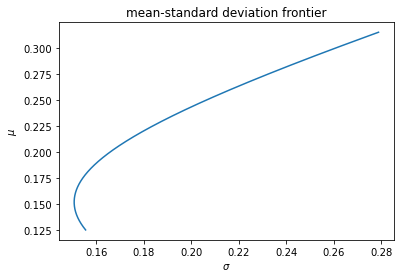

In [202]:
#b)

#computing mean and std of the portfolio
weight = np.linspace(0, 1.0, num=1000)
expreturn = weight*Apple_expret+(1-weight)*pg_expret
std = np.sqrt(weight**2*Apple_std**2+(1-weight)**2*pg_std**2+2*corr*Apple_std*pg_std*weight*(1-weight))

#plot the frontier
plt.plot(std, expretuern)
plt.xlabel('$\sigma$')
plt.ylabel('$\mu$')
plt.title('mean-standard deviation frontier')

In [203]:
# c)
#finding gmv portfolio
gmv = np.argmin(std)

#gmv potfolio
apple_weights = weight[gmv]
pg_weights = 1-apple_weights
gmv_retuern = expreturn[gmv]
gmv_std = std[gmv]
Sharp_r = (gmv_retuern-r_free)/gmv_std

print('Apple Weight:',apple_weights)
print('PG Weight:',pg_weights)
print('Global minimum variance portfolio expected return:', gmv_retuern)
print('Global minimum variance portfolio standard deviation:', gmv_std)
print('Sharp Ratio:', Sharp_r)

Apple Weight: 0.14014014014014015
PG Weight: 0.8598598598598599
Global minimum variance portfolio expected return: 0.1515600258858169
Global minimum variance portfolio standard deviation: 0.15067182599853363
Sharp Ratio: 0.906340817075821


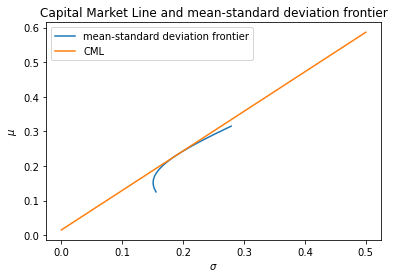

In [204]:
#d)
SRatio=(expreturn-r_free)/std
maxSR = np.max(SRatio)
x= np.linspace(0, 0.5, num=2)
CML=r_free+maxSR*x

plt.plot(std, expretuern, label= 'mean-standard deviation frontier')
plt.plot(x, CML, label='CML')
plt.xlabel('$\sigma$')
plt.ylabel('$\mu$')
plt.title('Capital Market Line and mean-standard deviation frontier')
plt.legend()

In [205]:
#(e)

tan=np.argmax(SRatio)
p_return = 0.5

#the proportion invested in the tangency portfolio
weight_tan = (p_return-r_free)/(expreturn[tan]-r_free)
weight_apple = weight_tan*weight[tan]
weight_pg = weight_tan*(1-weight[tan])
weight_rf = 1-weight_tan

#primting results
print('Tangency portfolio optimal dollar investment, in mln USD:', weight_tan*10)
print('Apple stock optimal dollar investment, in mln USD:', weight_apple*10)
print('PG stock optimal dollar investment, in mln USD:', weight_pg*10)
print('Risk-free asset optimal dollar investment, in mln USD:', weight_rf*10)

Tangency portfolio optimal dollar investment, in mln USD: 22.351454383335895
Apple stock optimal dollar investment, in mln USD: 12.59646528310121
PG stock optimal dollar investment, in mln USD: 9.754989100234686
Risk-free asset optimal dollar investment, in mln USD: -12.351454383335895


In [209]:
#(f)
a=(Apple_expret-r_free)/(weight_apple*Apple_std**2 + weight_pg*Apple_std*pg_std*corr)
print('Risk-aversion coef:', a)

Risk-aversion coef: 2.6941648971359013
